# Hypervector Capacity



Hypervector and hypercomputing is a set of theoretical constructs for using high-dimensional vectors for computation. This algebra is directly linked to the computations performed by neural networks. Although many agree that neural networks are computing, and theoretical studies point that recurrent neural networks (RNN) are universal, the theoretical process through which this computation is achieved is still unknown. Further, claims of Universality are based on RNNs that can have infinite dimensionality, and the relationships between the dimensionality of RNNs and the computational complexity of their computational task is unknown. 

These are experiments exploring the capabilities of hypervectors. These studies illustrate the fundamental information theoretic abilities of high-dimensional computations. We illustrate several strategies in storing and retrieving information from hypervectors, and link hypervector algebra to the operation of RNNs and liquid state machines. 



## Storing probabilities in hypervectors

Many machine learning algorithms require statistical analysis of input streams, and hypervector algebra provides mechanisms for encoding and reading these values on the fly. We first illustrate the most straight-forward process of encoding probabilities of individual letters, and show that the probabilities stored in the hypervector can be accurately recalled. 

We compare this to an alternative strategy where we encode the log values of the count, instead of the probabilities. This enables us to quickly compute joint probabilities, and provides better proportional accuracy for low-probability events (somewhat at the cost of losing accuracy for high-probability events).



In [1]:
import random_idx
import utils
import pickle
import time
import string
from pylab import *
%matplotlib inline

height has been deprecated.

2016-04-07 11:28


The data set we are working with is the text for "Alice in Wonderland". Here we are loading the text and converting all of the letters to lowercase and removing the punctuation.

In [2]:
fdict = open("raw_texts/texts_english/alice_in_wonderland.txt")
alice_text = fdict.read().lower()
punct = string.punctuation + string.digits

for i in punct:
    if i == '-':
        alice_text = alice_text.replace(i, ' ')
    else:
        alice_text = alice_text.replace(i, '')
    
alice_text = alice_text.replace('\n', ' ')
alice_text = alice_text.replace('\r','')
alice_text = alice_text.replace('\t','')
alice_text = alice_text[504:137330] # taking out the header/footer text

### Storing information about letter statistics in hypervectors

In order to store statistics about letters in hypervectors, each letter needs a unique high-dimensional representation. The representation we utilize in this work is based on hypercomputing with binary (+1, -1) vectors (Kanerva, 19xx). This representation is simple and has the nice property that each hypervector is its own inverse. These representations can be chosen at random independently, and the convenience of high-dimensions ensures that the similarity of these randomly chosen representations will be quite low.

The advantages of hypercomputing are most present with very high-dimensional representations, and so we begin using hypervectors with dimensionality of 10,000 ($N=10000$).

In [3]:
N = 10000
letter_vectors = 2 * (np.random.randn(len(random_idx.alphabet), N) > 0) - 1
letters = random_idx.alphabet.replace(' ', '_')

To store the statistics of each letter in the "Alice in Wonderland" text, we create a new hypervector, alice_vector1, that will contain the information. We cycle through each letter of the text, and add the letter's corresponding hypervector to alice_vector1 which will accumulate the counts for each letter. Finally, normalize by the length of the text to store the probabilities. This can be done with a few lines of code:

In [4]:
alice_vector1 = np.zeros(N)
for l in alice_text:
    alice_vector1 += letter_vectors[random_idx.alphabet.find(l), :]
alice_vector1 = alice_vector1 / len(alice_text)
hyp_prob1 = np.dot(letter_vectors, alice_vector1.T) / N

We also want to get the actual values of the occurence of each letter in the text to compare.

In [5]:
letter_counts = np.zeros(len(random_idx.alphabet))

for i,letter in enumerate(random_idx.alphabet):
    letter_counts[i] = alice_text.count(letter)

letter_prob = letter_counts / sum(letter_counts)

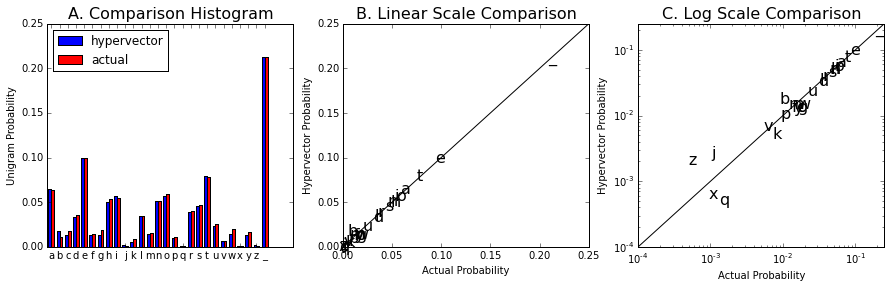

In [6]:
figure(figsize=(15,4))

ax1 = subplot(131)

bar(arange(len(hyp_prob1))+0.15, abs(hyp_prob1), width=0.35, color='b', label='hypervector')
bar(arange(len(letter_prob))+0.5, letter_prob, width=0.35, color='r', label='actual')

ax1.set_xticks(arange(len(hyp_prob1))+0.5)
th = ax1.set_xticklabels(list(letters))

ax1.legend(loc='upper left')
ax1.set_ylabel('Unigram Probability')
ax1.set_title('A. Comparison Histogram', fontsize=16)

plt_range = [1e-4, 0.25]

ax2 = subplot(132)
plot(plt_range, plt_range, 'k')

ax3 = subplot(133)
plot(plt_range, plt_range, 'k')

for i,l in enumerate(letters):
    if letter_prob[i] < 1e-7:
        continue
        
    # abs to deal with potential negatives
    ax2.text(letter_prob[i], abs(hyp_prob1[i]), 
         l, fontsize=16, ha='center', va='center')
    
    ax3.text(letter_prob[i], abs(hyp_prob1[i]), 
         l, fontsize=16, ha='center', va='center')

ax2.set_xlim(plt_range)
ax2.set_ylim(plt_range)

ax2.set_xlabel('Actual Probability')
ax2.set_ylabel('Hypervector Probability')
ax2.set_title('B. Linear Scale Comparison', fontsize=16)

ax3.set_xlim(plt_range)
ax3.set_xscale('log')
ax3.set_ylim(plt_range)
ax3.set_yscale('log')

ax3.set_xlabel('Actual Probability')
ax3.set_ylabel('Hypervector Probability')
ax3.set_title('C. Log Scale Comparison', fontsize=16)

**Figure 1. Statistics of unigrams in alice and wonderland text:** A. Histograms of unigram probabilities stored in the hypervector compared with the actual probability in the text. The small amount of noise in the hypervector is due to the expected small dot product of nearly orthogonal representations. B. Scatter plot comparison of letter probabilities and values stored in the hypervector. C. Log scale of scatter plot comparion. Very low-probability values are proportionally more noisy.


### Storing the log values

There could be several advantages to storing the log values of the counts in hypervectors. This could reduce the amount of proportional noise for low-likelihood values. Further, storing the log likelihoods could be useful for quickly computing the products of probabilities.

In order to store the log counts in the hypervector, we weight the letter_vectors based on the number of occurences that are already stored in the hypervector.


In [7]:
alice_vector_log = np.zeros(N)
letter_val = np.zeros(len(alice_text))
count_vector = 2 * (np.random.randn(N) > 0) - 1

for il,l in enumerate(alice_text):
    # Read out the log count of the letter value
    letter_val[il] = np.dot(letter_vectors[random_idx.alphabet.find(l),:], alice_vector_log.T) / N
    # Only increment the hypervector value for this letter based on its count
    alice_vector_log += 1.0 / (np.exp(letter_val[il])) * letter_vectors[random_idx.alphabet.find(l),:]
    
    # store the count in the hypervector too, we need this to decode the probability
    cv = np.dot(count_vector, alice_vector_log.T) / N    
    alice_vector_log += 1.0 / (np.exp(cv)) * count_vector 

alice_vector_log = alice_vector_log
hyp_prob_log = np.dot(letter_vectors, alice_vector_log.T) / N

This process should then store the log values of each letter over time, we can compare this to the expected log plot as we encounter each letter going through the text.

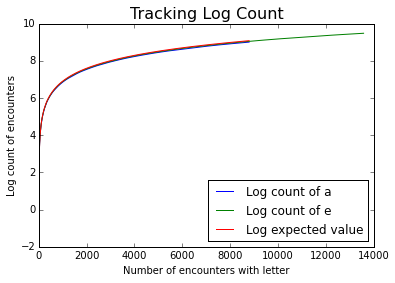

In [8]:
import re
idxs1 = np.array([match.start() for match in re.finditer('a', alice_text)])
idxs2 = np.array([match.start() for match in re.finditer('e', alice_text)])

plot(letter_val[idxs1], label='Log count of a')
plot(letter_val[idxs2], label='Log count of e')
plot(np.log(arange(len(idxs1))+1), label='Log expected value')
legend(loc='lower right')
xlabel('Number of encounters with letter')
ylabel('Log count of encounters')
title('Tracking Log Count', fontsize=16)


**Figure 2. Readout and weighted storage to encode log counts on the fly:** The log counts of each letter was stored by accumulating the letter vectors proportionally to their current log counts stored in the hypervector. Weighting the letter vectors accurately stored the log values as each letter was encountered during the encoding.



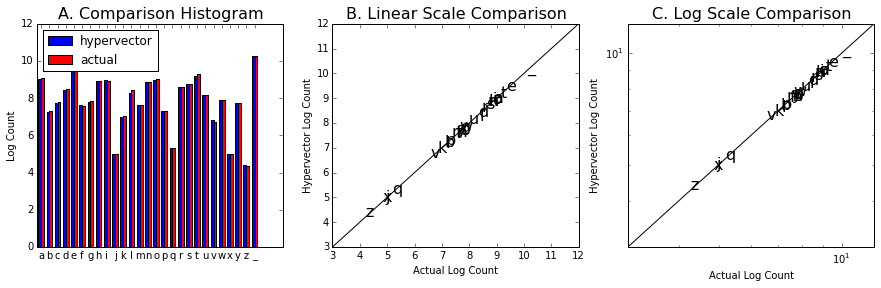

In [9]:
figure(figsize=(15,4))

ax1 = subplot(131)

bar(arange(len(hyp_prob_log))+0.15, hyp_prob_log, width=0.35, color='b', label='hypervector')
bar(arange(len(letter_prob))+0.5, np.log(letter_counts), width=0.35, color='r', label='actual')

ax1.set_xticks(arange(len(hyp_prob1))+0.5)
th = ax1.set_xticklabels(list(letters))

ax1.legend(loc='upper left')
ax1.set_ylabel('Log Count')
ax1.set_title('A. Comparison Histogram', fontsize=16)

plt_range = [3e0, 12]

ax2 = subplot(132)
plot(plt_range, plt_range, 'k')

ax3 = subplot(133)
plot(plt_range, plt_range, 'k')

for i,l in enumerate(letters):
    if letter_prob[i] < 1e-7:
        continue
        
    # abs to deal with potential negatives
    ax2.text(np.log(letter_counts[i]), abs(hyp_prob_log[i]), 
         l, fontsize=16, ha='center', va='center')
    
    ax3.text(np.log(letter_counts[i]), abs(hyp_prob_log[i]), 
         l, fontsize=16, ha='center', va='center')

ax2.set_xlim(plt_range)
ax2.set_ylim(plt_range)

ax2.set_xlabel('Actual Log Count')
ax2.set_ylabel('Hypervector Log Count')
ax2.set_title('B. Linear Scale Comparison', fontsize=16)

ax3.set_xlim(plt_range)
ax3.set_xscale('log')
ax3.set_ylim(plt_range)
ax3.set_yscale('log')

ax3.set_xlabel('Actual Log Count')
ax3.set_ylabel('Hypervector Log Count')
ax3.set_title('C. Log Scale Comparison', fontsize=16)

**Figure 3. Log statistics of unigrams in alice and wonderland text:** A. Histograms of unigram log counts stored in the hypervector compared with the actual log counts in the text. B. Scatter plot comparison of letter probabilities and values stored in the hypervector. C. Log scale of scatter plot comparion. Very low-probability values are not as proportionally noisy.


In [10]:
# Can get the full probability reconstruction by decoding each letter and the count
hyp_prob_log_r = np.exp((np.dot(letter_vectors, alice_vector_log.T) 
                         - np.dot(count_vector, alice_vector_log.T)))

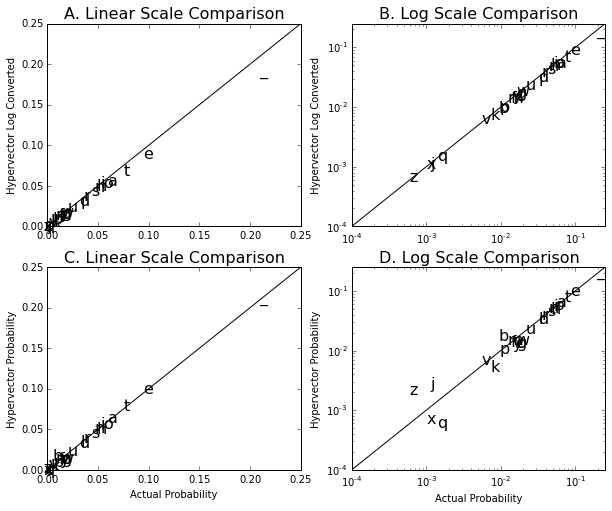

In [11]:
figure(figsize=(10, 8))

plt_range = [1e-4, 0.25]

ax1=subplot(221)
ax1.plot(plt_range, plt_range, 'k')
ax2=subplot(222)
ax2.plot(plt_range, plt_range, 'k')
ax3=subplot(223)
ax3.plot(plt_range, plt_range, 'k')
ax4=subplot(224)
ax4.plot(plt_range, plt_range, 'k')

for i,ll in enumerate(letters):
    if letter_counts[i] < 1:
        continue
    
    # adding plt_range[0] so that log(1)=0 doesnt plot at -infinity on the log axis
    ax1.text(letter_counts[i]/len(alice_text) + plt_range[0], hyp_prob_log_r[i] + plt_range[0],
         ll, fontsize=16, ha='center', va='center')    
    ax3.text(letter_counts[i]/len(alice_text) + plt_range[0], abs(hyp_prob1[i]) + plt_range[0],
         ll, fontsize=16, ha='center', va='center')
    
    ax2.text(letter_counts[i]/len(alice_text) + plt_range[0], hyp_prob_log_r[i] + plt_range[0], 
         ll, fontsize=16, ha='center', va='center')
    ax4.text(letter_counts[i]/len(alice_text) + plt_range[0], abs(hyp_prob1[i]) + plt_range[0],
         ll, fontsize=16, ha='center', va='center')

ax1.set_xlim([0, 0.25])
ax1.set_ylim([0, 0.25])

ax1.set_ylabel('Hypervector Log Converted')
ax1.set_title('A. Linear Scale Comparison', fontsize=16)

ax3.set_xlim([0, 0.25])
ax3.set_ylim([0, 0.25])

ax3.set_xlabel('Actual Probability')
ax3.set_ylabel('Hypervector Probability')
ax3.set_title('C. Linear Scale Comparison', fontsize=16)

ax2.set_xlim([1e-4, 0.25])
ax2.set_xscale('log')
ax2.set_ylim([1e-4, 0.25])
ax2.set_yscale('log')

ax2.set_ylabel('Hypervector Log Converted')
ax2.set_title('B. Log Scale Comparison', fontsize=16)

ax4.set_xlim([1e-4, 0.25])
ax4.set_xscale('log')
ax4.set_ylim([1e-4, 0.25])
ax4.set_yscale('log')

ax4.set_xlabel('Actual Probability')
ax4.set_ylabel('Hypervector Probability')
ax4.set_title('D. Log Scale Comparison', fontsize=16)

** Figure 4. Comparison of direct versus log storage:** A and B. Scatter plot of reconstructed probabilities from storage of log counts, shown on linear (A) and log (B) scales. C and D. Scatter plot of directly stored probabilities (same as Fig 1. B and C).

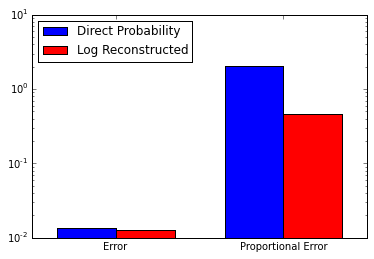

In [12]:
prob_error = (sum((letter_prob - abs(hyp_prob1))**2))**0.5
prob_log_error = (sum((letter_prob - np.exp(abs(hyp_prob_log))/len(alice_text))**2))**0.5

# is this the correct way of computing it? it doesn't seem right...
prob_perror = (sum((letter_prob - abs(hyp_prob1))/letter_prob)**2)**0.5
prob_log_perror = (sum((letter_prob - np.exp(abs(hyp_prob_log))/len(alice_text))/letter_prob)**2)**0.5

bar(np.array([0, 1]) + 0.15, np.array([prob_error, prob_perror]), 
    width=0.35, label='Direct Probability', color='b')
bar(np.array([0, 1]) + 0.5, np.array([prob_log_error, prob_log_perror]), 
    width=0.35, label='Log Reconstructed', color='r')

ax = gca()
ax.set_yscale('log')
ax.legend(loc='upper left')
ax.set_xticks([0.5, 1.5])
ax.set_xticklabels(['Error', 'Proportional Error'])

**Figure 5. Error Comparison of Direct vs. Log Encoding of Probabilities:** Direct encoding has less error, because large probability items are very accurate and low probability items are noisy. This means that there is a lot of proportional error. Encoding the log slightly increases the error, but greatly decreases the proportional error.

A particular advantage of encoding the statistics in log space is that the joint probabilities of the letters can quickly be computed from the hypervector by creating a semantic pointer. The semantic pointer asks the hypervector to decode a combination of letters, and so to decode the joint probability of 'a', and 'b' (i.e. decode p('a') * p('b')), one would construct a semantic pointer: $sp = a + b - 2 * count$, where $a$ is the hypervector that represents 'a', $b$ represents 'b', and $count$ is the hypervector for the count.


In [13]:
test_joints = ['ae', 'ab', 'ed', 'xy', 'qu', 'pax', 'is', 'awe', 'some']

actual_joint_prob = np.ones(len(test_joints))
hyp_joint_prob_log = np.ones(len(test_joints))
hyp_joint_prob = np.ones(len(test_joints))

for ti, joint_letters in enumerate(test_joints):
    joint_vec = np.zeros(N)
    actual_joint_prob[ti] = 1
    hyp_joint_prob[ti] = 1

    for l in joint_letters:
        lidx = random_idx.alphabet.find(l)
        joint_vec += letter_vectors[lidx,:]
    
        actual_joint_prob[ti] *= letter_prob[lidx]
        hyp_joint_prob[ti] *= abs(hyp_prob1[lidx])
    
    joint_vec -= count_vector * len(joint_letters)

    hyp_joint_prob_log[ti] = np.exp(np.dot(joint_vec, alice_vector_log.T)/N)
    


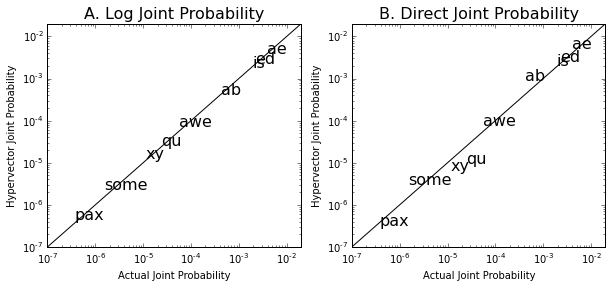

In [14]:
figure(figsize=(10,4))

plt_range = [1e-7, 2e-2]

ax = subplot(121)
plot(plt_range, plt_range, 'k')
for ti, ll in enumerate(test_joints):
    text(actual_joint_prob[ti], hyp_joint_prob_log[ti], ll,
        fontsize=16, ha='center', va='center')
    
ax = gca()
ax.set_xlim(plt_range)
ax.set_xscale('log')
ax.set_ylim(plt_range)
ax.set_yscale('log')
ax.set_xlabel('Actual Joint Probability')
ax.set_ylabel('Hypervector Joint Probability')
ax.set_title('A. Log Joint Probability', fontsize=16)

ax2 = subplot(122)
plot(plt_range, plt_range, 'k')
for ti, ll in enumerate(test_joints):
    text(actual_joint_prob[ti], hyp_joint_prob[ti], ll,
        fontsize=16, ha='center', va='center')
    
ax = gca()
ax.set_xlim(plt_range)
ax.set_xscale('log')
ax.set_ylim(plt_range)
ax.set_yscale('log')
ax.set_xlabel('Actual Joint Probability')
ax.set_ylabel('Hypervector Joint Probability')
ax.set_title('B. Direct Joint Probability', fontsize=16)

**Figure 6. Computing joint probabilities from log hypervector:** A. The joint probability for several examples are decoded from the Log hypervector and plotted against the true joint probabilities. B. The joint probabilities are computed from the direct probability encoding hypervector. More errors accumulate due to the noise of low-probability items.

### Storing bigrams in hypervectors

With the hypervector algebra, more than just unigram statistics can be computed in a straightforward manner. By using the permutation (np.roll) and binding operations ($*$ - element-wise multiply), tokens for higher-order values can be stored.

In [15]:
ngram = 2
ngram_vector = np.ones(N) # temp hypervector to encode the bigram
alice_vector2 = np.zeros(N) # bigram statistics hypervector

# First, build-up the ngram vector
for i in range(ngram-1):
    lidx = random_idx.alphabet.find(alice_text[i])
    ngram_vector = np.roll(ngram_vector, 1) * letter_vectors[lidx, :]

# Now go through the text and accumulate stats
for i,l in enumerate(alice_text[(ngram-1):]):
    lidx = random_idx.alphabet.find(l)
    ngram_vector = np.roll(ngram_vector, 1) * letter_vectors[lidx, :]
    
    alice_vector2 += ngram_vector
    
    # remove the first letter of the ngram
    fidx = random_idx.alphabet.find(alice_text[i])
    ngram_vector = ngram_vector * np.roll(letter_vectors[fidx, :], (ngram-1))
        
alice_vector2 = alice_vector2 / len(alice_text)


The bigram hypervector does not contain any information about the unigram statistics (because we did not store this information). When we attempt to decode unigram values from the bigram hypervector, then we will get very small values near zero.


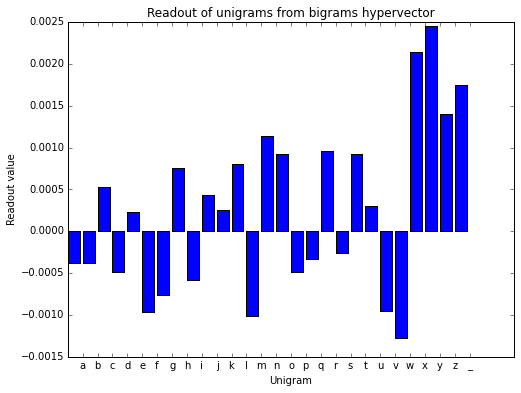

In [16]:
unigram_prob2 = np.dot(letter_vectors, alice_vector2.T) / N
figure(figsize=(8,6));

bar(arange(len(unigram_prob2)), unigram_prob2)

ax = gca()

ax.set_xticks(arange(len(letters))+1)
th = ax.set_xticklabels(list(letters))

title('Readout of unigrams from bigrams hypervector')
xlabel('Unigram');
ylabel('Readout value')

** Figure 7. Unigrams are not encoded in bigram hypervector:** unigrams that are decoded from a bigrams hypervector produce low values in the dot product.


Now, we can decode all of the bigrams from the hypervector and compare the statistics stored in the hypervector to the true values in the text.

In [17]:
hyp_prob2 = np.zeros(len(random_idx.alphabet)**2)
letter_counts2 = np.zeros(len(random_idx.alphabet)**2)
letter_pairs = []
c = 0

for i, letter1 in enumerate(random_idx.alphabet):
    for j, letter2 in enumerate(random_idx.alphabet):
        
        ls = letter1+letter2
        
        letter_counts2[c] = alice_text.count(ls)
        
        vector = np.roll(letter_vectors[i,:], 1) * letter_vectors[j,:]        
        hyp_prob2[c] = np.dot(vector, alice_vector2.T) / N
        
        letter_pairs.append(ls.replace(' ', '_'))

        c+=1

#%%
letter_prob2 = letter_counts2 / sum(letter_counts2)


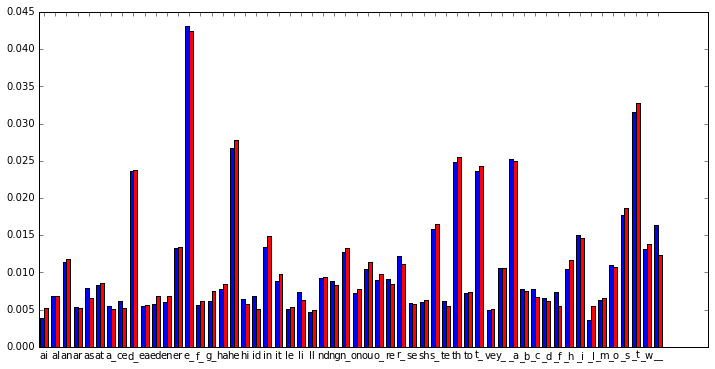

In [18]:
figure(figsize=(12,6))

sig_idx = find(letter_prob2 > 0.005)

b1=bar(arange(len(hyp_prob2[sig_idx]))+0.15, hyp_prob2[sig_idx], width=0.35, color='b')
b2=bar(arange(len(letter_prob2[sig_idx]))+0.5, letter_prob2[sig_idx], width=0.35, color='r')

ax = gca()

ax.set_xticks(arange(len(hyp_prob2[sig_idx]))+0.5)

pair_labels = []
for i in sig_idx:
    pair_labels.append(letter_pairs[i])
    
t1 = ax.set_xticklabels(pair_labels)

**Figure 8. Histogram comparison of top bigrams:** The probabilities of each bigram was decoded from the hypervector, and the bigrams with probabilities greater than 0.5% are compared with their true probabilities.

Again, the directly encoded bigram hypervector encodes the high-probability items with high-precision, but proportionally low-precision for the low-probability items.

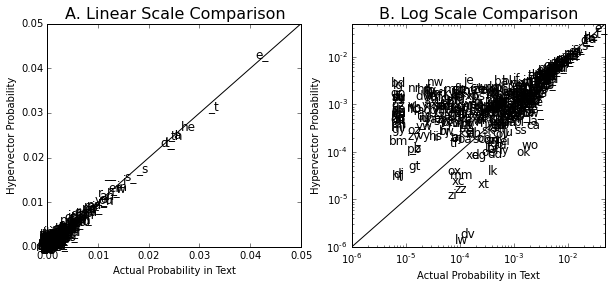

In [19]:
figure(figsize=(10,4))

plt_range = [1e-6, 5e-2]

ax1 = subplot(121)
plot(plt_range, plt_range, 'k')
ax2 = subplot(122)
plot(plt_range, plt_range, 'k')

for i,ll in enumerate(letter_pairs):
    if letter_prob2[i] < 1e-7:
        continue
        
    ax1.text(letter_prob2[i], abs(hyp_prob2[i]), 
             ll, fontsize=12,ha='center', va='center')
    ax2.text(letter_prob2[i], abs(hyp_prob2[i]), 
             ll, fontsize=12,ha='center', va='center')

ax1.set_xlim(plt_range)
ax1.set_ylim(plt_range)
ax1.set_xlabel('Actual Probability in Text')
ax1.set_ylabel('Hypervector Probability')

ax1.set_title('A. Linear Scale Comparison', fontsize=16)

    
ax2.set_xlim(plt_range)
ax2.set_xscale('log')
ax2.set_ylim(plt_range)
ax2.set_yscale('log')

ax2.set_xlabel('Actual Probability in Text')
ax2.set_ylabel('Hypervector Probability')
ax2.set_title('B. Log Scale Comparison', fontsize=16)


**Figure 9. Comparison of bigram statistics:** A and B. Bigram probabilities from hypervector are compared to the true probabilities in a linear (A) and log (B) scale. Low probability bigram are proportionally noisier than high-probability bigrams.

We can again encode the log of statistics as we encounter each bigram by weighting the bigram vectors based on the value currently stored in the hypervector. We can see similar advantages to encoding the bigrams this way as the unigrams.

In [20]:
ngram = 2
ngram_vector = np.ones(N)
alice_vector_log2 = np.zeros(N)

for i in range(ngram-1):
    lidx = random_idx.alphabet.find(alice_text[i])
    ngram_vector = np.roll(ngram_vector, 1) * letter_vectors[lidx, :]

for i,l in enumerate(alice_text[(ngram-1):]):
    lidx = random_idx.alphabet.find(l)

    ngram_vector = np.roll(ngram_vector, 1) * letter_vectors[lidx, :]
    
    ngram_val = np.dot(ngram_vector, alice_vector_log2.T) / N
    alice_vector_log2 += 1.0 / (np.exp(ngram_val)) * ngram_vector
    
    cv = np.dot(count_vector, alice_vector_log2.T) / N    
    alice_vector_log2 += 1.0 / (np.exp(cv)) * count_vector # store the count in the hypervector too

    # remove the first letter of the ngram
    fidx = random_idx.alphabet.find(alice_text[i])

    ngram_vector = ngram_vector * np.roll(letter_vectors[fidx, :], (ngram-1))
    

In [21]:
hyp_prob_log2 = np.zeros(len(random_idx.alphabet)**2)

hyp_prob_log2_r = np.zeros(len(random_idx.alphabet)**2)
np.exp((np.dot(letter_vectors, alice_vector_log.T) 
                         - np.dot(count_vector, alice_vector_log.T))/N)
letter_counts2 = np.zeros(len(random_idx.alphabet)**2)
letter_pairs = []
c = 0

for i, letter1 in enumerate(random_idx.alphabet):
    for j, letter2 in enumerate(random_idx.alphabet):
        
        ls = letter1+letter2
        
        letter_counts2[c] = alice_text.count(ls)

        letter_pairs.append(ls.replace(' ', '_'))

        vector = np.roll(letter_vectors[i,:], 1) * letter_vectors[j,:]
        
        hyp_prob_log2[c] = np.dot(vector, alice_vector_log2.T) / N
        
        hyp_prob_log2_r[c] = np.exp((np.dot(vector, alice_vector_log2.T)
                                     - np.dot(count_vector, alice_vector_log2.T))/N)
        c+=1

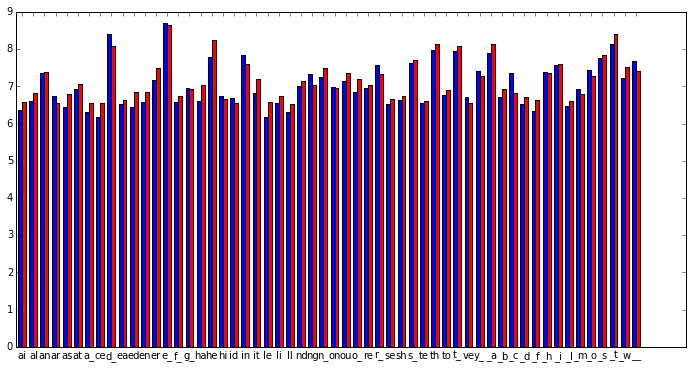

In [22]:
figure(figsize=(12,6))

sig_idx = find(letter_prob2 > 0.005)

b1=bar(arange(len(hyp_prob_log2[sig_idx]))+0.15, hyp_prob_log2[sig_idx], width=0.35, color='b')
b2=bar(arange(len(letter_counts2[sig_idx]))+0.5, np.log(letter_counts2[sig_idx]), width=0.35, color='r')

ax = gca()

ax.set_xticks(arange(len(letter_prob2[sig_idx]))+0.5)

pair_labels = []
for i in sig_idx:
    pair_labels.append(letter_pairs[i])
    
t1 = ax.set_xticklabels(pair_labels)

**Figure 10. Histogram comparison of top bigrams:** The log counts of each bigram was decoded from the hypervector, and the bigrams with probabilities greater than 0.5% are compared with their true log counts.

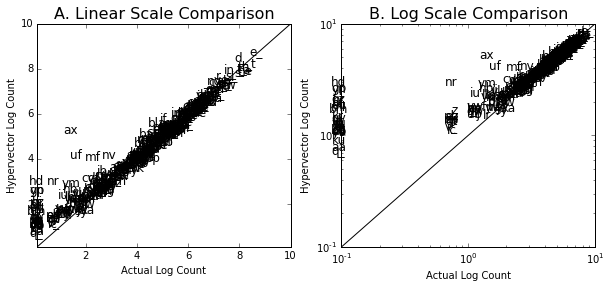

In [23]:
figure(figsize=(10,4))

plt_range = [1e-1, 1e1]
ax1 = subplot(121)
plot(plt_range, plt_range, 'k')
ax2 = subplot(122)
plot(plt_range, plt_range, 'k')

for i,ll in enumerate(letter_pairs):
    if letter_counts2[i] < 1:
        continue
        
    ax1.text(np.log(letter_counts2[i] + plt_range[0]), abs(hyp_prob_log2[i]) + plt_range[0], 
             ll, fontsize=12,ha='center', va='center')
    ax2.text(np.log(letter_counts2[i] + plt_range[0]), abs(hyp_prob_log2[i]) + plt_range[0], 
             ll, fontsize=12,ha='center', va='center')

ax1.set_xlim(plt_range)
ax1.set_ylim(plt_range)
ax1.set_xlabel('Actual Log Count')
ax1.set_ylabel('Hypervector Log Count')

ax1.set_title('A. Linear Scale Comparison', fontsize=16)

    
ax2.set_xlim(plt_range)
ax2.set_xscale('log')
ax2.set_ylim(plt_range)
ax2.set_yscale('log')

ax2.set_xlabel('Actual Log Count')
ax2.set_ylabel('Hypervector Log Count')
ax2.set_title('B. Log Scale Comparison', fontsize=16)


**Figure 11. Comparison of bigram statistics:** A and B. Bigram log counts from hypervector are compared to the true log counts in a linear (A) and log (B) scale.

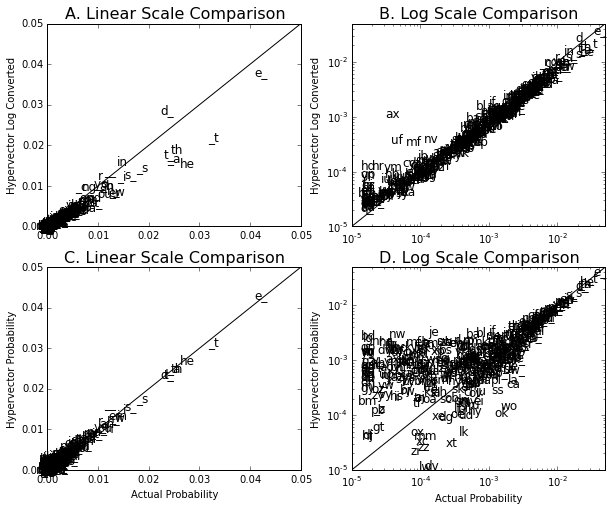

In [24]:
figure(figsize=(10, 8))

plt_range = [1e-5, 0.05]

ax1=subplot(221)
ax1.plot(plt_range, plt_range, 'k')
ax2=subplot(222)
ax2.plot(plt_range, plt_range, 'k')
ax3=subplot(223)
ax3.plot(plt_range, plt_range, 'k')
ax4=subplot(224)
ax4.plot(plt_range, plt_range, 'k')

for i,ll in enumerate(letter_pairs):
    if letter_counts2[i] < 1:
        continue
    
    ax1.text(letter_counts2[i]/len(alice_text) + plt_range[0], hyp_prob_log2_r[i] + plt_range[0],
         ll, fontsize=12, ha='center', va='center')    
    ax3.text(letter_counts2[i]/len(alice_text) + plt_range[0], abs(hyp_prob2[i]) + plt_range[0],
         ll, fontsize=12, ha='center', va='center')
    
    ax2.text(letter_counts2[i]/len(alice_text) + plt_range[0], hyp_prob_log2_r[i] + plt_range[0], 
         ll, fontsize=12, ha='center', va='center')
    ax4.text(letter_counts2[i]/len(alice_text) + plt_range[0], abs(hyp_prob2[i]) + plt_range[0],
         ll, fontsize=12, ha='center', va='center')

ax1.set_xlim(plt_range)
ax1.set_ylim(plt_range)

ax1.set_ylabel('Hypervector Log Converted')
ax1.set_title('A. Linear Scale Comparison', fontsize=16)

ax3.set_xlim(plt_range)
ax3.set_ylim(plt_range)

ax3.set_xlabel('Actual Probability')
ax3.set_ylabel('Hypervector Probability')
ax3.set_title('C. Linear Scale Comparison', fontsize=16)

ax2.set_xlim(plt_range)
ax2.set_xscale('log')
ax2.set_ylim(plt_range)
ax2.set_yscale('log')

ax2.set_ylabel('Hypervector Log Converted')
ax2.set_title('B. Log Scale Comparison', fontsize=16)

ax4.set_xlim(plt_range)
ax4.set_xscale('log')
ax4.set_ylim(plt_range)
ax4.set_yscale('log')

ax4.set_xlabel('Actual Probability')
ax4.set_ylabel('Hypervector Probability')
ax4.set_title('D. Log Scale Comparison', fontsize=16)

**Figure 12. Comparison of log storage of probabilities versus direct storage for bigrams:** A and B. The probability of each bigram was decoded from the log based hypervector and shown on a linear (A) and log (B) scale. C and D. The direct encoding of bigram probabilities is shown on a linear (C) and log (D) scale. 

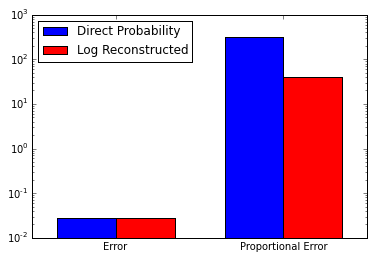

In [25]:
prob_error2 = sum((letter_prob2 - abs(hyp_prob2))**2)**0.5
prob_log_error2 = sum((letter_prob2 - hyp_prob_log2_r)**2)**0.5

nz_idxs = np.nonzero(letter_prob2>1e-5)
# is this the correct way of computing it? it doesn't seem right...
prob_perror2 = sum(((letter_prob2[nz_idxs] - abs(hyp_prob2[nz_idxs]))/letter_prob2[nz_idxs])**2)**0.5
prob_log_perror2 = sum(((letter_prob2[nz_idxs] - hyp_prob_log2_r[nz_idxs])/letter_prob2[nz_idxs])**2)**0.5

bar(np.array([0, 1]) + 0.15, np.array([prob_error2, prob_perror2]), 
    width=0.35, label='Direct Probability', color='b')
bar(np.array([0, 1]) + 0.5, np.array([prob_log_error2, prob_log_perror2]), 
    width=0.35, label='Log Reconstructed', color='r')

ax = gca()
ax.set_yscale('log')
ax.legend(loc='upper left')
ax.set_xticks([0.5, 1.5])
ax.set_xticklabels(['Error', 'Proportional Error'])

**Figure 13. Bigram error comparison of direct versus log probability encoding.** The linear error and the proportional error both actually are improved by the log encoding of the bigram statistics.

## Trigrams

We go through the exercise again with trigrams. There are more trigrams than the dimensionality of the hypervector (but not necessarilly all will be seen), which could increase further the noise caused by the hypercomputing framework.

In [26]:
27**3

19683

In [27]:
ngram = 3
ngram_vector = np.ones(N)
alice_vector3 = np.zeros(N)
alice_vector_log3 = np.zeros(N)

for i in range(ngram-1):
    lidx = random_idx.alphabet.find(alice_text[i])
    ngram_vector = np.roll(ngram_vector, 1) * letter_vectors[lidx, :]

for i,l in enumerate(alice_text[(ngram-1):]):
    lidx = random_idx.alphabet.find(l)

    ngram_vector = np.roll(ngram_vector, 1) * letter_vectors[lidx, :]
    
    alice_vector3 += ngram_vector
    
    ngram_val = np.dot(ngram_vector, alice_vector_log3.T) / N
    alice_vector_log3 += 1.0 / (np.exp(abs(ngram_val))) * ngram_vector
    
    cv = np.dot(count_vector, alice_vector_log3.T) / N    
    alice_vector_log3 += 1.0 / (np.exp(cv)) * count_vector # store the count in the hypervector too

    # remove the first letter of the ngram
    fidx = random_idx.alphabet.find(alice_text[i])

    ngram_vector = ngram_vector * np.roll(letter_vectors[fidx, :], (ngram-1))

alice_vector3 = alice_vector3 / len(alice_text)

In [28]:
hyp_prob3 = np.zeros(len(random_idx.alphabet)**3)
hyp_prob_log3 = np.zeros(len(random_idx.alphabet)**3)
hyp_prob_log3_r = np.zeros(len(random_idx.alphabet)**3)

letter_counts3 = np.zeros(len(random_idx.alphabet)**3)


letter_trigrams = []
c = 0

for i, letter1 in enumerate(random_idx.alphabet):
    for j, letter2 in enumerate(random_idx.alphabet):
        for k, letter3 in enumerate(random_idx.alphabet):
            
            lt = letter1+letter2+letter3
        
            letter_counts3[c] = alice_text.count(lt)
            
            
            letter_trigrams.append(lt.replace(' ', '_'))
            
            vector = np.roll(letter_vectors[i,:], 2) * np.roll(letter_vectors[j,:], 1) * letter_vectors[k,:]
            
            hyp_prob3[c] = np.dot(vector, alice_vector3.T) / N
            hyp_prob_log3[c] = np.dot(vector, alice_vector_log3.T) / N
            
            
            hyp_prob_log3_r[c] = np.exp((np.dot(vector, alice_vector_log3.T)
                                     - np.dot(count_vector, alice_vector_log3.T))/N)
            c+=1

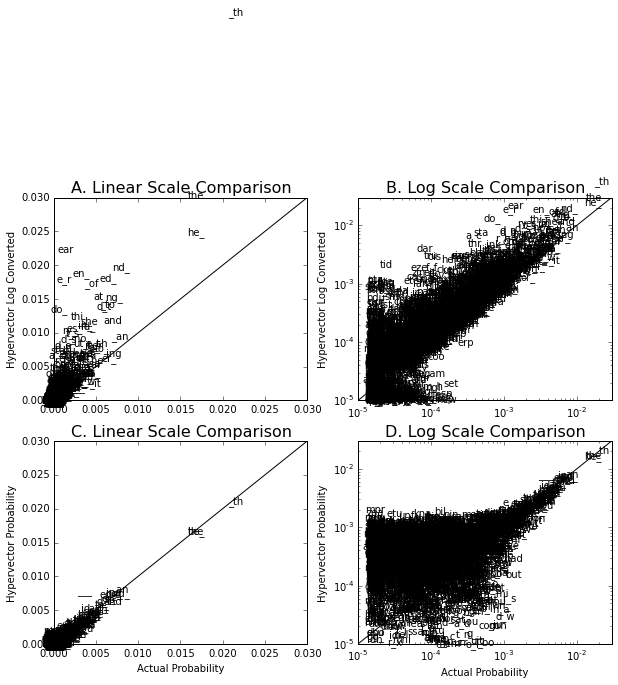

In [29]:
figure(figsize=(10, 8))

plt_range = [1e-5, 0.03]

ax1=subplot(221)
ax1.plot(plt_range, plt_range, 'k')
ax2=subplot(222)
ax2.plot(plt_range, plt_range, 'k')
ax3=subplot(223)
ax3.plot(plt_range, plt_range, 'k')
ax4=subplot(224)
ax4.plot(plt_range, plt_range, 'k')

for i,ll in enumerate(letter_trigrams):
    if letter_counts3[i] < 1:
        continue
    
    ax1.text(letter_counts3[i]/len(alice_text) + plt_range[0], hyp_prob_log3_r[i] + plt_range[0],
         ll, fontsize=10, ha='center', va='center')    
    ax3.text(letter_counts3[i]/len(alice_text) + plt_range[0], abs(hyp_prob3[i]) + plt_range[0],
         ll, fontsize=10, ha='center', va='center')
    
    ax2.text(letter_counts3[i]/len(alice_text) + plt_range[0], hyp_prob_log3_r[i] + plt_range[0], 
         ll, fontsize=10, ha='center', va='center')
    ax4.text(letter_counts3[i]/len(alice_text) + plt_range[0], abs(hyp_prob3[i]) + plt_range[0],
         ll, fontsize=10, ha='center', va='center')

ax1.set_xlim(plt_range)
ax1.set_ylim(plt_range)

ax1.set_ylabel('Hypervector Log Converted')
ax1.set_title('A. Linear Scale Comparison', fontsize=16)

ax3.set_xlim(plt_range)
ax3.set_ylim(plt_range)

ax3.set_xlabel('Actual Probability')
ax3.set_ylabel('Hypervector Probability')
ax3.set_title('C. Linear Scale Comparison', fontsize=16)

ax2.set_xlim(plt_range)
ax2.set_xscale('log')
ax2.set_ylim(plt_range)
ax2.set_yscale('log')

ax2.set_ylabel('Hypervector Log Converted')
ax2.set_title('B. Log Scale Comparison', fontsize=16)

ax4.set_xlim(plt_range)
ax4.set_xscale('log')
ax4.set_ylim(plt_range)
ax4.set_yscale('log')

ax4.set_xlabel('Actual Probability')
ax4.set_ylabel('Hypervector Probability')
ax4.set_title('D. Log Scale Comparison', fontsize=16)

**Figure 14. Comparison of log storage of probabilities versus direct storage for trigrams:** A and B. The probability of each bigram was decoded from the log based hypervector and shown on a linear (A) and log (B) scale. C and D. The direct encoding of bigram probabilities is shown on a linear (C) and log (D) scale. 

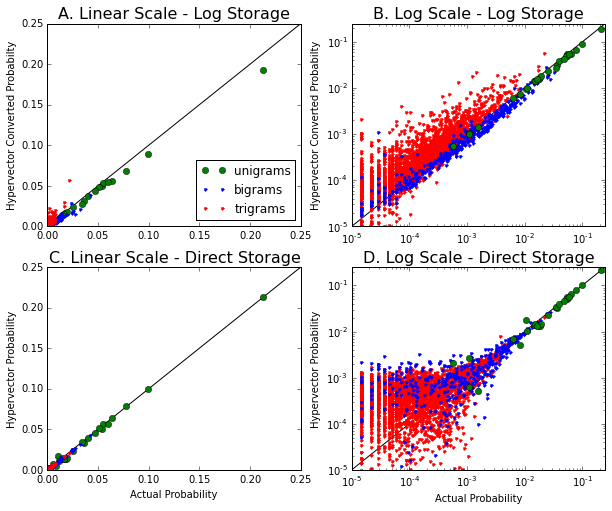

In [30]:
figure(figsize=(10,8))

plt_range = [1e-5, 0.25]


ax1= subplot(221)
ax1.plot(plt_range, plt_range, 'k')
ax1.plot(letter_counts/len(alice_text), hyp_prob_log_r, 'og', label='unigrams')
ax1.plot(letter_counts2/len(alice_text), hyp_prob_log2_r, '.b', label='bigrams')
ax1.plot(letter_counts3/len(alice_text), hyp_prob_log3_r, '.r', label='trigrams')

ax1.set_title('A. Linear Scale - Log Storage', fontsize=16)
ax1.set_ylabel('Hypervector Converted Probabilty')
ax1.legend(loc='lower right')

ax2 = subplot(222)
ax2.plot(plt_range, plt_range, 'k')
ax2.plot(letter_counts3/len(alice_text), hyp_prob_log3_r, '.r', label='trigrams')
ax2.plot(letter_counts2/len(alice_text), hyp_prob_log2_r, '.b', label='bigrams')
ax2.plot(letter_counts/len(alice_text), hyp_prob_log_r, 'og', label='unigrams')

ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlim(plt_range)
ax2.set_ylim(plt_range)
ax2.set_title('B. Log Scale - Log Storage', fontsize=16)
ax2.set_ylabel('Hypervector Converted Probabilty')

ax3 = subplot(223)
ax3.plot(plt_range, plt_range, 'k')

ax3.plot(letter_counts/len(alice_text), abs(hyp_prob1), 'og')
ax3.plot(letter_counts2/len(alice_text), abs(hyp_prob2), '.b')
ax3.plot(letter_counts3/len(alice_text), abs(hyp_prob3), '.r')

ax3.set_title('C. Linear Scale - Direct Storage', fontsize=16)
ax3.set_xlabel('Actual Probability')
ax3.set_ylabel('Hypervector Probability')

ax4 = subplot(224)
ax4.plot(plt_range, plt_range, 'k')

ax4.plot(letter_counts3/len(alice_text), abs(hyp_prob3), '.r')
ax4.plot(letter_counts2/len(alice_text), abs(hyp_prob2), '.b')
ax4.plot(letter_counts/len(alice_text), abs(hyp_prob1), 'og')

ax4.set_xscale('log')
ax4.set_yscale('log')
ax4.set_xlim(plt_range)
ax4.set_ylim(plt_range)
ax4.set_title('D. Log Scale - Direct Storage', fontsize=16)
ax4.set_ylabel('Hypervector Probability')
ax4.set_xlabel('Actual Probability')


**Figure 15. Accuracy comparison of storage strategies for different n-grams:** Log storage strategy reduces proportional error. Trigram hypervector noise is increasing due to larger number of potential trigrams to store over bigrams.

### Adjusting N with full stats

In this section, we will explore hypervectors with the log stats of all unigrams, bigrams and trigrams. This will be a lot of data to encode, and as can be seen in the figure above, the more data we store, the noisier the data become. 

We will adjust the value of N in order to observe how the accuracy of the probabilities changes as we adjust the dimensionality of the hypervector.



In [ ]:
def create_log_hypervector(text, letter_vectors, count_vector, ngrams=[1, 2, 3]):
    
    dN = letter_vectors.shape[1]
    
    log_hyp_vec = np.zeros(dN)
    
    # this isn't the most efficient way, now looping over the text for each ngram
    # could still do it looping once, but lazy for now...
    for ngram in ngrams:
        ngram_vector = np.ones(dN)
    
        for i in range(ngram-1):
            lidx = random_idx.alphabet.find(alice_text[i])
            ngram_vector = np.roll(ngram_vector, 1) * letter_vectors[lidx, :]

        for i,l in enumerate(text[(ngram-1):]):
            lidx = random_idx.alphabet.find(l)

            ngram_vector = np.roll(ngram_vector, 1) * letter_vectors[lidx, :]


            ngram_val = np.dot(ngram_vector, log_hyp_vec.T) / dN
            log_hyp_vec += 1.0 / (np.exp(abs(ngram_val))) * ngram_vector
            
            # I'm using roll to keep the count for each ngram
            cv = np.dot(np.roll(count_vector, ngram), log_hyp_vec.T) / dN    
            log_hyp_vec += 1.0 / (np.exp(cv)) * np.roll(count_vector, ngram)

            # remove the first letter of the ngram
            fidx = random_idx.alphabet.find(text[i])

            ngram_vector = ngram_vector * np.roll(letter_vectors[fidx, :], (ngram-1))

    return log_hyp_vec

In [ ]:
def decode_unigram_logvec(hyp_vec, letter_vectors, count_vector):
    N = hyp_vec.shape[0]
    hyp_prob_log_r = np.exp((np.dot(letter_vectors, hyp_vec.T) 
                             - np.dot(np.roll(count_vector, 1), hyp_vec.T))/N)

    letter_counts = np.zeros(len(random_idx.alphabet))

    for i,letter in enumerate(random_idx.alphabet):
        letter_counts[i] = alice_text.count(letter)
    
    return hyp_prob_log_r, letter_counts / len(alice_text), random_idx.alphabet.replace(' ', '_')


In [ ]:

def decode_bigram_logvec(hyp_vec, letter_vectors, count_vector):
    N = hyp_vec.shape[0]

    hyp_prob_log2_r = np.zeros(len(random_idx.alphabet)**2)
    letter_counts2 = np.zeros(len(random_idx.alphabet)**2)
    letter_pairs = []
    c = 0

    for i, letter1 in enumerate(random_idx.alphabet):
        for j, letter2 in enumerate(random_idx.alphabet):

            ls = letter1+letter2

            letter_counts2[c] = alice_text.count(ls)

            letter_pairs.append(ls.replace(' ', '_'))

            vector = np.roll(letter_vectors[i,:], 1) * letter_vectors[j,:]

            hyp_prob_log2[c] = np.dot(vector, hyp_vec.T) / N

            hyp_prob_log2_r[c] = np.exp((np.dot(vector, hyp_vec.T)
                                         - np.dot(np.roll(count_vector, 2), hyp_vec.T))/N)
            c+=1
            
    return hyp_prob_log2_r, letter_counts2 / (len(alice_text)-1), letter_pairs


In [ ]:

def decode_trigram_logvec(hyp_vec, letter_vectors, count_vector):
    
    N = hyp_vec.shape[0]
    hyp_prob_log3_r = np.zeros(len(random_idx.alphabet)**3)
    letter_counts3 = np.zeros(len(random_idx.alphabet)**3)
    
    letter_trigrams = []
    c = 0
    
    for i, letter1 in enumerate(random_idx.alphabet):
        for j, letter2 in enumerate(random_idx.alphabet):
            for k, letter3 in enumerate(random_idx.alphabet):

                lt = letter1+letter2+letter3
                letter_counts3[c] = alice_text.count(lt)

                letter_trigrams.append(lt.replace(' ', '_'))
                
                vector = np.roll(letter_vectors[i,:], 2) * np.roll(letter_vectors[j,:], 1) * letter_vectors[k,:]
                hyp_prob_log3_r[c] = np.exp((np.dot(vector, hyp_vec.T)
                                         - np.dot(np.roll(count_vector, 3), hyp_vec.T))/N)
                c += 1
                
    return hyp_prob_log3_r, letter_counts3 / (len(alice_text)-2), letter_trigrams

In [ ]:

def plot_hypvec_comparison(letter_probs, hyp_probs):
    figure(figsize=(10,8))

    plt_range = [1e-5, 0.25]


    ax1= subplot(221)
    ax1.plot(plt_range, plt_range, 'k')

    ax2 = subplot(222)
    ax2.plot(plt_range, plt_range, 'k')

    for i, lp, hp in zip(range(len(letter_probs)), letter_probs, hyp_probs):
        ax1.plot(lp, hp, '.', label=str(i+1) + '-grams')
        ax2.plot(lp, hp, '.', label=str(i+1) + '-grams')

    ax1.set_title('A. Linear Scale - Log Storage', fontsize=16)
    ax1.set_ylabel('Hypervector Converted Probabilty')
    ax1.legend(loc='lower right')

    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.set_xlim(plt_range)
    ax2.set_ylim(plt_range)
    ax2.set_title('B. Log Scale - Log Storage', fontsize=16)
    ax2.set_ylabel('Hypervector Converted Probabilty')



In [ ]:
#test_N = [1e2]
test_N = [1e3, 1e4, 5e4, 1e5, 2e5]

create_time = np.zeros(len(test_N))
decode_time = np.zeros(len(test_N))

lps_N = []
hps_N = []

letter_vec_N = []
count_vec_N = []
hyp_vec_N = []

for i, N in enumerate(test_N):
    
    tcstart = time.time()
    
    letter_vectors = 2 * (np.random.randn(len(random_idx.alphabet), N) > 0) - 1
    count_vector = 2 * (np.random.randn(N) > 0) - 1
    hyp_vec = create_log_hypervector(alice_text, letter_vectors, count_vector)
    
    create_time[i] = time.time() - tcstart
    
    
    tdstart = time.time()
    
    hp1, lp1, unigrams = decode_unigram_logvec(hyp_vec, letter_vectors, count_vector)
    hp2, lp2, bigrams = decode_bigram_logvec(hyp_vec, letter_vectors, count_vector)
    hp3, lp3, trigrams = decode_trigram_logvec(hyp_vec, letter_vectors, count_vector)
    
    decode_time[i] = time.time() - tdstart
    
    print N, 'Duration: ', create_time[i], decode_time[i]
    
    hps = [hp1, hp2, hp3]
    lps = [lp1, lp2, lp3]
    plot_hypvec_comparison(lps, hps)
    
    letter_vec_N.append(letter_vectors)
    count_vec_N.append(count_vector)
    hyp_vec_N.append(hyp_vec)
    lps_N.append(lps)
    hps_N.append(hps)
    

So this is telling because there is both very high-probability items (e.g. spaces, and 'e') and low probability items (such as weird trigrams like gxf), which may never show up. 

I think that the high probability items can accidentally have huge errors (in the linear space) because of the exponential. One problem may be that the counter values have noise, and this noise can effect everything. If the counter is a little bit off, then there can be a global shift. This could be done better by keeping better track of the counter (make redundant counter variables and average them, for instance). 

We can see now the clear relationships between the capacity of the hypervector and the noise of the items. The top plot shows $N=1000$, which does not have enough capacity to store the information and there is wild amounts of noise -- made especially worse by the exponential. When $N=10,000$ then the noise still dominates, but there is a little bit of connection between the hypervector values and the true values. With $N>50,000$ the noise gets smaller and smaller (with the exception of 2-grams in the 100k case, which seem to have a global offset, likely due to the count value having large noise).







In [ ]:
error_N = np.zeros((len(test_N), 3))
perror_N = np.zeros((len(test_N), 3))

for i, (lps, hps) in enumerate(zip(lps_N, hps_N)):
    for j, (lp, hp) in enumerate(zip(lps, hps)):
        error_N[i,j] = np.sum((lp - hp)**2)**0.5
        
        nz_idx = np.nonzero(lp>1.0/len(alice_text))
        perror_N[i,j] = np.sum(((lp[nz_idx]-hp[nz_idx])/lp[nz_idx])**2)**0.5

        

In [ ]:
filename = 'data/log_hypvec-test_N-' + str(len(test_N)) + '-n' + time.strftime('%y%m%d') + '.npz'

np.savez(filename, hyp_vec_N=hyp_vec_N, letter_vec_N=letter_vec_N, count_vec_N=count_vec_N, 
         hps_N=hps_N, lps_N=lps_N, create_time=create_time, decode_time=decode_time, 
        error_N=error_N, perror_N=perror_N)

In [ ]:
cols = cm.get_cmap('copper', 4)

In [ ]:
cols(0.25)

In [ ]:
figure(figsize=(10,4))

cols = cm.get_cmap('copper', len(test_N))
ax1 = subplot(121)
for iN, Nv in enumerate(test_N):
    ax1.bar(arange(3) + 1.0*iN / (len(test_N)+1), error_N[iN,:], width=1.0/(len(test_N)+1),
        color=cols(iN), label='N=%d' % Nv)
ax1.legend(loc='upper right')

ax1.set_xticks([0.5, 1.5, 2.5])
ax1.set_xticklabels(['Unigrams', 'Bigrams', 'Trigrams'])
ax1.set_yscale('log')
ax1.set_ylabel('Error')

ax2 = subplot(122)

for iN, Nv in enumerate(test_N):
    ax2.bar(arange(3) + 1.0*iN / (len(test_N)+1), perror_N[iN,:], width=1.0/(len(test_N)+1),
        color=cols(iN), label='N=%d' % Nv)

ax2.set_xticks([0.5, 1.5, 2.5])
ax2.set_xticklabels(['Unigrams', 'Bigrams', 'Trigrams'])
ax2.set_yscale('log')
ax2.set_ylabel('Proportional Error')

In [ ]:
error_N = np.zeros((len(test_N), 3))
perror_N = np.zeros((len(test_N), 3))

for i, lps in enumerate(lps_N):
    for j, lp in enumerate(lps_N[i]):
        error_N[i,j] = np.sum((lps_N[i][j] - hps_N[i][j])**2)**0.5
        
        nz_idx, = np.nonzero(lps_N[i][j] > 1.0/len(alice_text))
        perror_N[i,j] = np.sum(((lps_N[i][j][nz_idx]-hps_N[i][j][nz_idx])/lps_N[i][j][nz_idx])**2)**0.5

        

In [ ]:
#plot(lps_N[1][1], hps_N[1][1], '.')
plot(lps_N[0][2], hps_N[2][2], '.')
plot(lps_N[3][2], hps_N[3][2], '.')

In [ ]:
ax1.set_yscale('log')



ax3 = subplot(223)
prob_log_error = np.mean((letter_probs - hyp_prob_log_r)**2)**0.5
prob_log_error2 = np.mean((letter_probs2 - hyp_prob_log2_r)**2)**0.5
prob_log_error3 = np.mean((letter_probs3 - hyp_prob_log3_r)**2)**0.5

nz_idxs2 = np.nonzero(letter_probs2>1.0/len(alice_text))
nz_idxs3 = np.nonzero(letter_probs3>1.0/len(alice_text))

bar(np.arange(3), [prob_log_error, prob_log_error2, prob_log_error3])

ax3.set_xticks([0.5, 1.5, 2.5])
ax3.set_xticklabels(['Uni', 'Bi', 'Tri'])
ax3.set_xlabel('Error')

ax4 = subplot(224)
prob_log_perror = np.mean(((letter_probs - hyp_prob_log_r)/letter_probs)**2)**0.5
prob_log_perror2 = np.mean(((letter_probs2[nz_idxs2] - hyp_prob_log2_r[nz_idxs2])/letter_probs2[nz_idxs2])**2)**0.5
prob_log_perror3 = np.mean(((letter_probs3[nz_idxs3] - hyp_prob_log3_r[nz_idxs3])/letter_probs3[nz_idxs3])**2)**0.5

bar(np.arange(3), [prob_log_perror, prob_log_perror2, prob_log_perror3])

ax4.set_yscale('log')
ax4.set_xticks([0.5, 1.5, 2.5])
ax4.set_xticklabels(['Uni', 'Bi', 'Tri'])
ax4.set_xlabel('Proportional Error')

In [ ]:
hyp_prob_log_r, letter_probs, unigrams = decode_unigram_logvec(hyp_vec_e4, letter_vectors, count_vector)
hyp_prob_log2_r, letter_probs2, bigrams = decode_bigram_logvec(hyp_vec_e4, letter_vectors, count_vector)
hyp_prob_log3_r, letter_probs3, trigrams = decode_trigram_logvec(hyp_vec_e4, letter_vectors, count_vector)

In [ ]:

lps = []
lps.append(letter_probs)
lps.append(letter_probs2)
lps.append(letter_probs3)
hps = []
hps.append(hyp_prob_log_r)
hps.append(hyp_prob_log2_r)
hps.append(hyp_prob_log3_r)

plot_hypvec_comparison(lps, hps)


In [ ]:
tstart = time.time()

N = 50000
letter_vectors = 2 * (np.random.randn(len(random_idx.alphabet), N) > 0) - 1
count_vector = 2 * (np.random.randn(N) > 0) - 1
hyp_vec_e4 = create_log_hypervector(alice_text, letter_vectors, count_vector)

print 'Duration:', time.time() - tstart


### Discussion

Storing the log values is advantageous over storing the probabilities directly for two reasons: 1. the low-probability values are better represented because the proportional error is much less, 2. the joint probabilities can be directly decoded with a semantic poiter.

By adding a new random index vector, called the count_vector in the code, we were able to encode the log probabilities without any *cheating*. The procedure for encoding the log values is really encoding the log of the counts of each letter. However, to get the probabilities one would need to retain the total number of values encounterd in order to normalize any readout. In order to keep track of the count, one cannot just simply normalize the log vector by the count like with the direct probability vector. It would be cheating to keep track of the count externally to the hypervector, and so to store the count an extra random index was created that keeps track of the total number of items. This can be used to then normalize any probability, and is simply done by adding the count_vector to the dereferencing hypervector. For instead to decode the normalized probability of 'the' in the trigram vector, one would create the semantic pointer:

$$
sm = r(r(t))*r(h)*e - count
$$

where $t$, $h$, $e$ and $count$ are the hypervectors that represent these elements, and $sm$ is the semantic pointer formed by their sum, $*$ is elementwise multiplication, and r implements permutation.  Because the log hypervector is storing the log values of the counts, this semantic pointer is actually computing the log of the probability (i.e. $log(trigram) - log(count) = log(\frac{trigram}{count})$).

The only necessary cheating is the need to exponentiate the log to recover the probability value:

$$
p('the') = exp(sm \cdot hyp)
$$

And so any joint probabilities could be dereferenced from the hypervectors. For instance, it is also possible to store the unigram, bigram and trigram stats in a single log hypervector and many bayesian statistics could be decoded using nice linear semantic pointers. 